In [1]:
from itertools import cycle
import matplotlib.pyplot as plt
from numpy import interp
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score
import os
import xgboost as xgb
from sklearn.preprocessing import label_binarize

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

D:\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def plotROC(n_classes,y_test,y_score):
    # 计算
    fpr, tpr, thread = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    # 绘图
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc.png',)
    plt.show()

# 计算准确率
def calculate_all_prediction(confMatrix):
    '''
    计算总精度,对角线上所有值除以总数
    :return:
    '''
    total_sum = confMatrix.sum()
    correct_sum = (np.diag(confMatrix)).sum()
    prediction = round(100 * float(correct_sum) / float(total_sum), 2)
    print('准确率:' + str(prediction) + '%')


def calculae_lable_prediction(confMatrix):
    '''
    计算每一个类别的预测精度:该类被预测正确的数除以该类的总数
    '''
    l = len(confMatrix)
    for i in range(l):
        label_total_sum = confMatrix.sum(axis=1)[i]
        label_correct_sum = confMatrix[i][i]
        prediction = round(100 * float(label_correct_sum) / float(label_total_sum), 2)
        print('精确率: {0} : {1} %'.format(i, prediction))

def calculate_label_recall(confMatrix):
    l = len(confMatrix)
    for i in range(l):
        label_total_sum = confMatrix.sum(axis=0)[i]
        label_correct_sum = confMatrix[i][i]
        prediction = round(100 * float(label_correct_sum) / float(label_total_sum), 2)
        print('召回率: {0} : {1} %'.format(i, prediction))

In [3]:
file = '代谢组数据 - 填充 by min - 副本2.csv'
df = pd.read_csv(file,engine='python')
features=df.columns.tolist()

feat_labels = df.columns[5:]
X=df[features[5:]]
y=df[features[4]]

pd.DataFrame(X)
pd.DataFrame(y)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

XGB结果

特征排序结果——————————————————————————————————————————————————
 1) 7-Methylxanthine               0.109102
 2) Putrescine                     0.091375
 3) Ascorbate                      0.067811
 4) PG(16:0_20:4)                  0.064361
 5) 3-Methoxytyrosine              0.056905
 6) Histamine                      0.048630
 7) LPC(26:1)                      0.044016
 8) Dopamine 4-o-sulfate           0.035082
 9) Erythose 4-phosphate           0.031728
10) PG(18:0_20:4)                  0.022895
11) LPG(18:0)                      0.021891
12) Glutathione                    0.019233
13) 8-Hydroxy-deoxyguanosine       0.018685
14) Pyroglutamic acid              0.018585
15) HexCer(d18:1/18:0)             0.016658
16) Cer(d18:1/24:1)                0.015644
17) TG(20:4_36:2)                  0.014714
18) Cadaverine                     0.013359
19) TG(22:6_38:1)                  0.011879
20) GD3(d34:1)                     0.010409
21) PE(36:1)                       0.010321
22) LPC(22:6)      

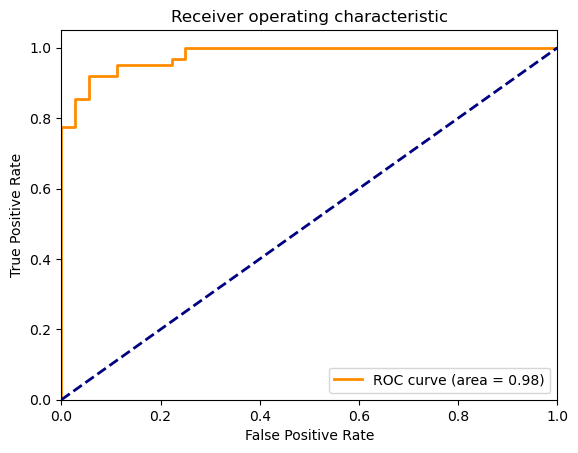

交叉验证得分：
[0.97435897 0.94871795 1.         1.         0.92307692 0.92307692
 0.94871795 0.94871795 0.8974359  0.94736842]
0.9511470985155196


In [4]:
model = xgb.XGBClassifier( learning_rate =0.1,
 n_estimators=200,
 max_depth=5)
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("特征排序结果——————————————————————————————————————————————————")
importances = model.feature_importances_
indices = np.argsort(importances)[::-1] # 下标排序
for f in range(X_train.shape[1]):   # x_train.shape[1]=13
    print("%2d) %-*s %f" % \
          (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
predictions=model.predict(X_test)
cm = confusion_matrix(y_true=Y_test, y_pred=predictions)
calculate_all_prediction(cm)
calculae_lable_prediction(cm)
calculate_label_recall(cm)
y_score = model.predict_proba(X_test)
plotROC(3,Y_test,y_score[:,1])

scores = cross_val_score(model, X_train, Y_train, cv=10)  #cv为迭代次数。
print("交叉验证得分：")
print(scores)
print(scores.mean())

RF结果

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      |

特征排序结果——————————————————————————————————————————————————
 1) Putrescine                     0.111428
 2) PG(16:0_20:4)                  0.091255
 3) Dopamine 4-o-sulfate           0.079523
 4) Ascorbate                      0.073970
 5) 3-Methoxytyrosine              0.065321
 6) Dopamine 3-o-sulfate           0.050801
 7) Dopa                           0.030649
 8) LPC(26:1)                      0.027701
 9) LPG(16:0)                      0.018351
10) 3-Hydroxy-N6,N6,N6-Trimethyllysine 0.014868
11) MG(18:0)                       0.011581
12) 3-Hydroxybutyric acid          0.009551
13) Aspartic acid                  0.008270
14) Erythose 4-phosphate           0.007749
15) Oxoglutaric acid               0.007236
16) Glutathione                    0.007213
17) 7-Methylxanthine               0.006516
18) LPC(16:1)                      0.005972
19) TG(22:6_36:2)                  0.005940
20) Histamine                      0.005565
21) TG(22:6_38:2)                  0.005327
22) PE(P-16:0/2

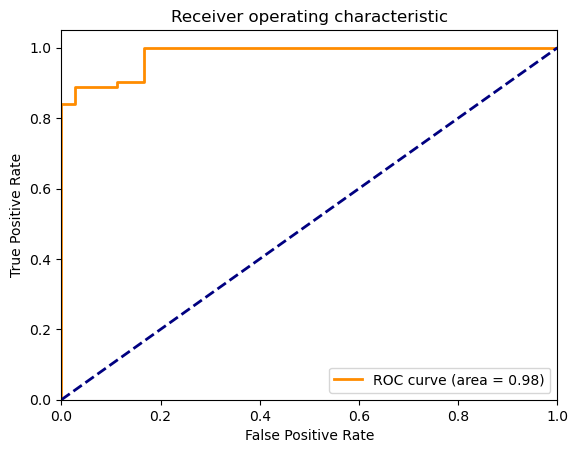

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 174 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done 197 out of 200 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    2.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Usi

交叉验证得分：
[1.         0.92307692 1.         0.94871795 0.97435897 0.94871795
 0.94871795 0.92307692 0.97435897 1.        ]
0.964102564102564


[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished


In [5]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(criterion='gini',max_features=25,n_estimators=200,random_state=1,n_jobs=2,verbose=1)
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("特征排序结果——————————————————————————————————————————————————")
importances = model.feature_importances_
indices = np.argsort(importances)[::-1] # 下标排序
for f in range(X_train.shape[1]):   # x_train.shape[1]=13
    print("%2d) %-*s %f" % \
          (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
predictions=model.predict(X_test)
cm = confusion_matrix(y_true=Y_test, y_pred=predictions)
calculate_all_prediction(cm)
calculae_lable_prediction(cm)
calculate_label_recall(cm)
y_score = model.predict_proba(X_test)
plotROC(3,Y_test,y_score[:,1])

scores = cross_val_score(model, X_train, Y_train, cv=10)  #cv为迭代次数。
print("交叉验证得分：")
print(scores)
print(scores.mean())

SVM

特征排序结果——————————————————————————————————————————————————
(238,)
(238,)
 1) 3-Methoxytyrosine              3.003805
 2) Dopamine 3-o-sulfate           1.979473
 3) LPI(18:0)                      1.275673
 4) Dopamine 4-o-sulfate           1.275482
 5) PE(P-16:0/22:4)                1.195730
 6) (3-O-sulfo)GalCer(d18:1/24:1)  1.193739
 7) 1-Methylhistidine              1.167596
 8) LPC(16:1)                      1.098919
 9) Uridine                        1.064647
10) HexCer(d18:1/24:0)             1.049898
11) Linoleic acid                  1.042459
12) Pyridoxamine                   1.000651
13) Paraxanthine                   0.867416
14) Oxoglutaric acid               0.864594
15) PE(38:5)                       0.859836
16) PE(34:1)                       0.852252
17) GM3(d36:1)                     0.851518
18) GB3(d18:1/24:1)                0.806136
19) TG(20:4_34:2)                  0.757863
20) 7-keto-Cholesterol             0.747146
21) GM3(d34:1)                     0.740269
22) A

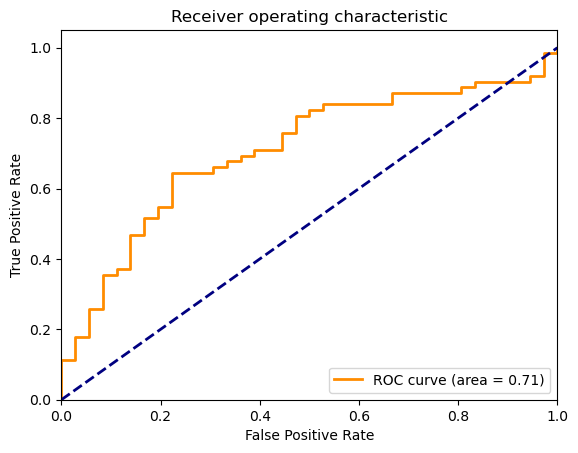

交叉验证得分：
[0.71794872 0.76923077 0.69230769 0.76923077 0.58974359 0.58974359
 0.64102564 0.71794872 0.69230769 0.63157895]
0.68110661268556


In [6]:
from sklearn import svm
model = svm.SVC(kernel = 'linear')
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("特征排序结果——————————————————————————————————————————————————")
coef = model.coef_
coef = np.abs(coef)
importances = np.sum(coef, axis=0)
indices = np.argsort(importances)[::-1] # 下标排序
print(importances.shape)
print(indices.shape)
for f in range(X_train.shape[1]):   # x_train.shape[1]=13
    print("%2d) %-*s %f" % \
          (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
predictions=model.predict(X_test)
cm = confusion_matrix(y_true=Y_test, y_pred=predictions)
calculate_all_prediction(cm)
calculae_lable_prediction(cm)
calculate_label_recall(cm)
y_score = model.decision_function(X_test)
print(y_score)
plotROC(3,Y_test,y_score)

scores = cross_val_score(model, X_train, Y_train, cv=10)  #cv为迭代次数。
print("交叉验证得分：")
print(scores)
print(scores.mean())


Cart

特征排序结果——————————————————————————————————————————————————
 1) Putrescine                     0.417612
 2) 3-Methoxytyrosine              0.264387
 3) 7-Methylxanthine               0.104866
 4) Dopamine 4-o-sulfate           0.055905
 5) PG(16:0_20:4)                  0.044968
 6) Thiamine                       0.030059
 7) PC(40:5)                       0.022626
 8) Histamine                      0.018881
 9) PE(P-16:0/20:4)                0.010821
10) N-Alpha-acetyllysine           0.010598
11) LacCer(d18:1/18:0)             0.010530
12) DG(16:0_20:4)                  0.008748
13) CE(22:6)                       0.000000
14) Cer(d18:1/16:0)                0.000000
15) Cer(d18:1/24:0)                0.000000
16) Cer(d18:1/18:0)                0.000000
17) CE(20:4)                       0.000000
18) Cer(d18:1/24:1)                0.000000
19) Cholesteryl hexoside           0.000000
20) Coenzyme Q10                   0.000000
21) CE(20:5)                       0.000000
22) cis-Aconitic ac

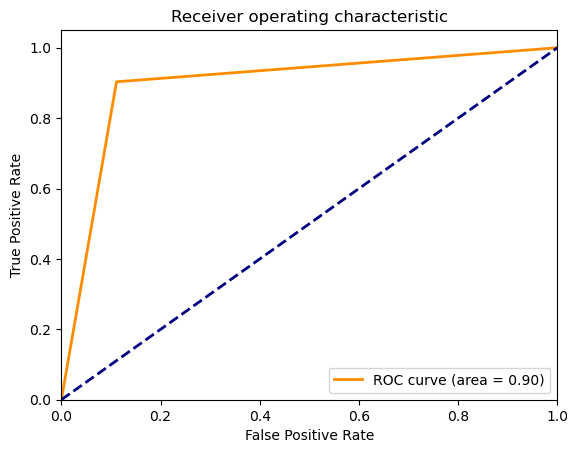

交叉验证得分：
[0.94871795 0.94871795 0.8974359  0.97435897 0.87179487 0.8974359
 0.84615385 0.92307692 0.87179487 0.86842105]
0.9047908232118758


In [7]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=42)
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("特征排序结果——————————————————————————————————————————————————")
importances = model.feature_importances_
indices = np.argsort(importances)[::-1] # 下标排序
for f in range(X_train.shape[1]):   # x_train.shape[1]=13
    print("%2d) %-*s %f" % \
          (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
predictions=model.predict(X_test)
cm = confusion_matrix(y_true=Y_test, y_pred=predictions)
calculate_all_prediction(cm)
calculae_lable_prediction(cm)
calculate_label_recall(cm)
y_score = model.predict_proba(X_test)
plotROC(3,Y_test,y_score[:,1])

scores = cross_val_score(model, X_train, Y_train, cv=10)  #cv为迭代次数。
print("交叉验证得分：")
print(scores)
print(scores.mean())

GBM

特征排序结果——————————————————————————————————————————————————
 1) Putrescine                     0.407295
 2) 3-Methoxytyrosine              0.264387
 3) 7-Methylxanthine               0.104866
 4) Dopamine 4-o-sulfate           0.055905
 5) PG(16:0_20:4)                  0.044968
 6) Thiamine                       0.030059
 7) PC(40:5)                       0.022882
 8) Histamine                      0.012866
 9) BMP(22:6/22:6)                 0.008660
10) 8-Hydroxy-deoxyguanosine       0.008229
11) PE(P-16:0/20:4)                0.007700
12) Glucosylsphingosine            0.005927
13) Stearoylcarnitine              0.003457
14) Taurine                        0.002971
15) 3-Hydroxykynurenine            0.002565
16) Ascorbate                      0.002097
17) CE(18:1)                       0.001648
18) DG(18:1/18:1)                  0.001638
19) PE(34:1)                       0.001606
20) (3-O-sulfo)GalCer(d18:1/24:1(2OH)) 0.001332
21) LPI(18:0)                      0.001076
22) N-Alpha-ace

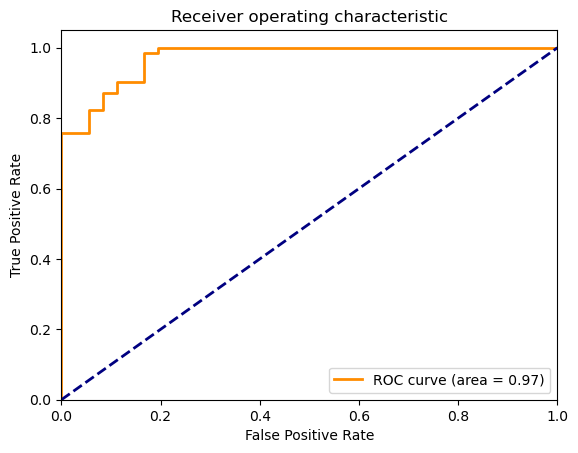

交叉验证得分：
[0.87179487 1.         0.8974359  1.         0.8974359  0.8974359
 0.84615385 0.8974359  0.8974359  0.92105263]
0.9126180836707152


In [8]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=10, random_state=42)
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("特征排序结果——————————————————————————————————————————————————")
importances = model.feature_importances_
indices = np.argsort(importances)[::-1] # 下标排序
for f in range(X_train.shape[1]):   # x_train.shape[1]=13
    print("%2d) %-*s %f" % \
          (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
predictions=model.predict(X_test)
cm = confusion_matrix(y_true=Y_test, y_pred=predictions)
calculate_all_prediction(cm)
calculae_lable_prediction(cm)
calculate_label_recall(cm)
y_score = model.predict_proba(X_test)
plotROC(3,Y_test,y_score[:,1])

scores = cross_val_score(model, X_train, Y_train, cv=10)  #cv为迭代次数。
print("交叉验证得分：")
print(scores)
print(scores.mean())

逻辑回归

D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


特征排序结果——————————————————————————————————————————————————
(238,)
(238,)
 1) LPC(16:0)                      0.180878
 2) Threonine                      0.161425
 3) Trigonelline                   0.120198
 4) PE(P-18:0/18:2)                0.090586
 5) Dopamine 3-o-sulfate           0.080082
 6) SM(d18:1/24:1)                 0.071184
 7) Serine                         0.067561
 8) PE(P-16:0/20:4)                0.060538
 9) 3-Methoxytyrosine              0.057909
10) PE(36:2)                       0.056707
11) Trimethylamine-N-oxide         0.054789
12) CE(16:1)                       0.051805
13) PE(38:4)                       0.051368
14) PC(38:4)                       0.049311
15) PE(P-16:0/22:6)                0.049025
16) PE(P-18:0/20:5)                0.048338
17) LPC(18:1)                      0.047871
18) LPC(18:0)                      0.047330
19) PE(40:6)                       0.046954
20) SEX-ID                         0.045900
21) MG(18:1)                       0.044918
22) P

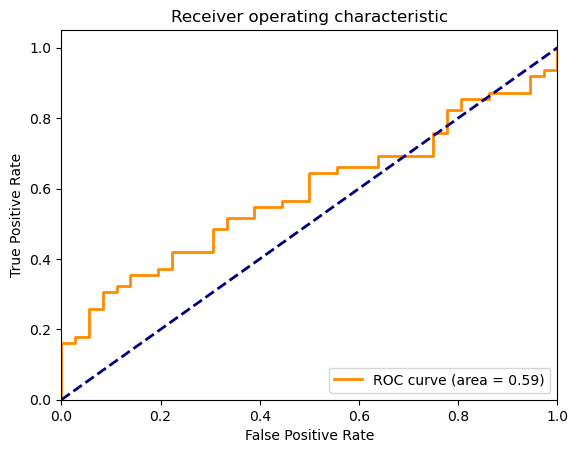

D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

交叉验证得分：
[0.71794872 0.56410256 0.79487179 0.74358974 0.51282051 0.51282051
 0.58974359 0.53846154 0.61538462 0.57894737]
0.6168690958164642


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

In [9]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0)
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("特征排序结果——————————————————————————————————————————————————")
coef = model.coef_
coef = np.abs(coef)
importances = np.sum(coef, axis=0)
indices = np.argsort(importances)[::-1] # 下标排序
print(importances.shape)
print(indices.shape)
for f in range(X_train.shape[1]):   # x_train.shape[1]=13
    print("%2d) %-*s %f" % \
          (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
predictions=model.predict(X_test)
cm = confusion_matrix(y_true=Y_test, y_pred=predictions)
calculate_all_prediction(cm)
calculae_lable_prediction(cm)
calculate_label_recall(cm)
y_score = model.decision_function(X_test)
plotROC(3,Y_test,y_score)

scores = cross_val_score(model, X_train, Y_train, cv=10)  #cv为迭代次数。
print("交叉验证得分：")
print(scores)
print(scores.mean())